# Customer Segmentation for E-commerce: EDA and Feature Engineering

# 0. Project Objective
The primary goal of this project is to perform customer segmentation for a UK-based online retailer. By leveraging clustering algorithms, we aim to uncover distinct customer profiles based on their transaction history. These insights can help the business understand customer preferences, enabling targeted marketing campaigns, personalized recommendations, and improved inventory management.

This notebook focuses on the initial, critical stages of the project:

1. Exploratory Data Analysis (EDA): To understand the structure, patterns, and quality of the raw transaction data.

2. Data Cleaning & Preprocessing: To handle missing values, duplicates, and outliers, ensuring the data is reliable for modeling.

3. Feature Engineering: To create meaningful new features that capture customer behavior, such as RFM (Recency, Frequency, Monetary) metrics and product category preferences.

The features engineered here will be used in subsequent stages to build and evaluate clustering models like K-Means and DBSCAN. The final clusters will be visualized using PCA and evaluated with the silhouette score to measure their quality.

In [1]:
# Importing necessary Libraries
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import CountVectorizer
import re
from wordcloud import WordCloud

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder

root = '/Users/mina/Documents/GitHub/customer_segmentation/'

# 1. Dataset Exploration
## 1.1 Data and Feature Descriptions

This dataset is from [The UCI Machine Learning Repository]('https://archive.ics.uci.edu/dataset/352/online+retail') and contains transactions occurring between 01/12/2010 and 09/12/2011 for a UK-based online retail store. The company primarily sells unique all-occasion gifts, and many of its customers are wholesalers.

The dataset contains 541,909 records and has the following 8 features:

* `InvoiceNo`: A 6-digit number uniquely assigned to each transaction. If this code starts with 'C', it indicates a cancellation.
* `StockCode`: A 5-digit number uniquely assigned to each distinct product.
* `Description`: The name of the product.
* `Quantity`: The number of units of each product per transaction.
* `InvoiceDate`: The date and time when the transaction occurred.
* `UnitPrice`: The price per unit of the product.
* `CustomerID`: A 5-digit number uniquely assigned to each customer.
* `Country`: The name of the country where the customer resides.

## 1.2 Import Data

In [2]:
# Load the dataset from a CSV file
data = pd.read_csv(root + 'online_retail.csv', encoding='ISO-8859-1')
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [3]:
# Check the dimensions of the dataframe
data.shape

(541909, 8)

In [4]:
# Check for duplicated rows
data.duplicated().sum()

5268

In [5]:
# Get a concise summary of the dataframe
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [6]:
# Check for missing values in each column
data.isna().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

** Initial Findings: **

* The dataset has 541909 rows and 8 columns.
* There are 135080 missing `CustomerID`s and 1454 `Description`s.
* There are 5268 duplicated rows in the dataset.
* Three ID columns (`InvoiceNo`, `StockCode`, `CustomerID`) is unique assigned value thus each ID should be treated Nominal *category* not a continous number as *float*.

## 1.3 Data Cleaning

In [7]:
# Remove duplicated rows from the dataset
data = data.drop_duplicates()
data.duplicated().sum()

0

In [8]:
# Check the percentage of missing values for key columns
print(f"Percentage of missing CustomerID: {round(data['CustomerID'].isna().sum() / len(data) * 100,2)}%")
print(f"Percentage of missing Description: {round(data['Description'].isna().sum() / len(data) * 100,2)}%")

Percentage of missing CustomerID: 25.16%
Percentage of missing Description: 0.27%


About 25% of records are missing a `CustomerID`. Since the primary goal is customer segmentation, records without a `CustomerID` are not useful for creating customer-level profiles and will be removed. The missing `Description` records (0.27%) are negligible and will also be dropped.

In [9]:
# Remove rows with missing Description or CustomerID
data = data.dropna(subset=['Description', 'CustomerID'])
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 401604 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    401604 non-null  object 
 1   StockCode    401604 non-null  object 
 2   Description  401604 non-null  object 
 3   Quantity     401604 non-null  int64  
 4   InvoiceDate  401604 non-null  object 
 5   UnitPrice    401604 non-null  float64
 6   CustomerID   401604 non-null  float64
 7   Country      401604 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 27.6+ MB


In [10]:
# Convert CustomerID from float to a string for categorical treatment
data['CustomerID'] = data['CustomerID'].astype(int).astype(str)
data.dtypes

InvoiceNo       object
StockCode       object
Description     object
Quantity         int64
InvoiceDate     object
UnitPrice      float64
CustomerID      object
Country         object
dtype: object

## 1.4 Exploratory Data Analysis (EDA)

### 1.4.1 Continous Variables

In [11]:
# Summary statistics for continous values
data[['Quantity', 'UnitPrice']].describe().round(2)

,Quantity,UnitPrice
count,401604.00,401604.00
mean,12.18,3.47
std,250.28,69.76
min,-80995.00,0.00
25%,2.00,1.25
50%,5.00,1.95
75%,12.00,3.75
max,80995.00,38970.00


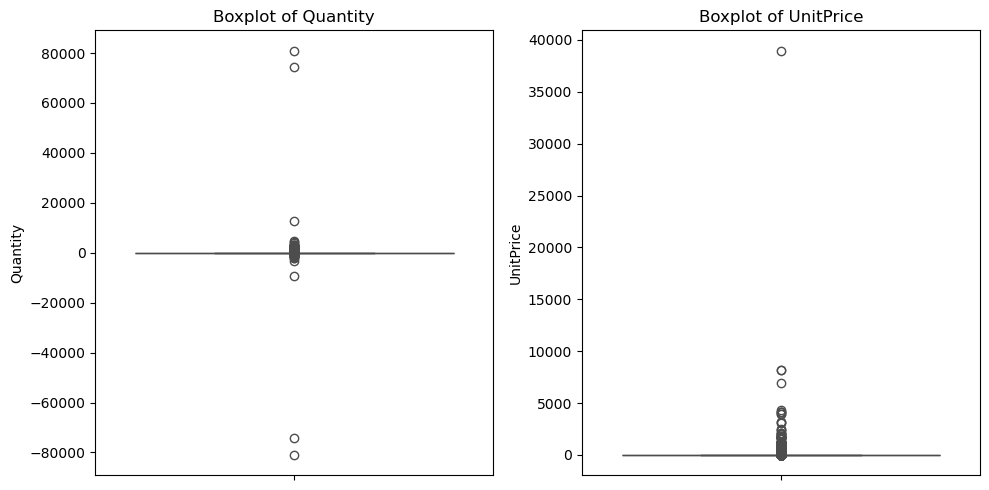

In [12]:
# Boxplot of Quantity and UnitPrice
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
sns.boxplot(y='Quantity', data=data, palette=['blue', 'red'], ax=ax[0])
sns.boxplot(y='UnitPrice', data=data, palette=['blue', 'red'], ax=ax[1])
ax[0].set_title('Boxplot of Quantity')
ax[1].set_title('Boxplot of UnitPrice')
plt.tight_layout()
plt.show()

**Observation**

* **Quantity**:
    * Negative values are present, which indicate canceled orders.
    * Extreme outliers (e.g., 80,995 and -80,995) exist, likely representing data entry errors or large canceled orders.
    * The distribution is heavily skewed, with a median of 5 units per transaction, suggesting most orders are small.

* **UnitPrice**:
   * The minimum price is 0.0, which could represent promotional items or data errors.
    * Extreme high values are present, skewing the mean. The median price of 1.95 suggests most items are low-cost gifts.
    * The distribution is also highly skewed due to outliers.

To handle these extreme and likely erroneous values, we will filter the data based on quantiles to remove the most unrealistic outliers.

In [13]:
# Define a function to calculate outlier cutoffs using the percentile method
def outlier_cutoffs(df, column, lower_pct=0.01, upper_pct=0.99):
    """Return cutoff values using Percentile methods."""
    # Percentile Method
    lower_pct_val = df[column].quantile(lower_pct)
    upper_pct_val = df[column].quantile(upper_pct)
    
    return {
        "Percentile_lower": lower_pct_val, "Percentile_upper": upper_pct_val
    }

In [14]:
# Calculate cutoffs for Quantity
outlier_cutoffs(data, "Quantity")

{'Percentile_lower': -2.0, 'Percentile_upper': 120.0}

In [15]:
# Calculate cutoffs for UnitPrice
outlier_cutoffs(data, "UnitPrice")

{'Percentile_lower': 0.21, 'Percentile_upper': 15.0}

In [16]:
# Filter the data to remove unrealistic outliers based on the 99th percentile
data = data[(data['Quantity'] > -2) & (data['Quantity'] < 100)]
data = data[(data['UnitPrice'] > 0.19) & (data['UnitPrice'] < 18)]

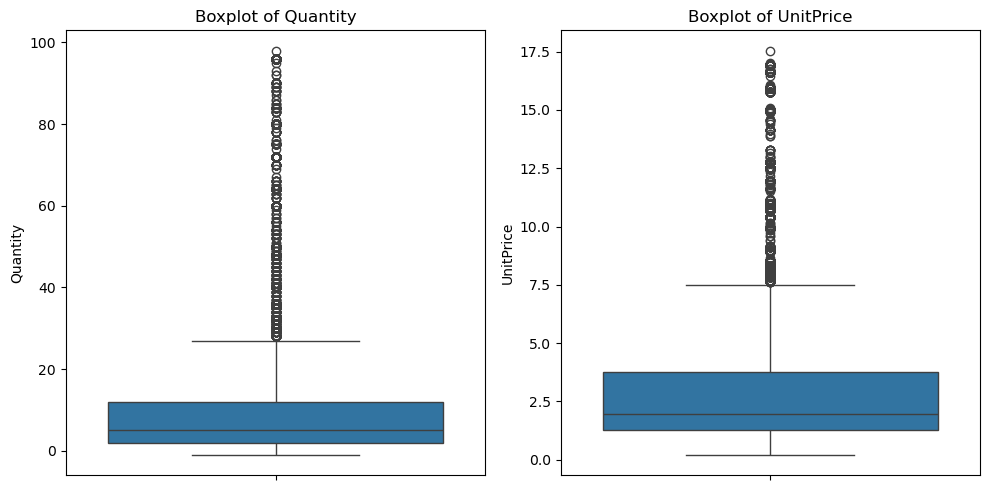

In [17]:
# Boxplots after removing outliers
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
sns.boxplot(y='Quantity', data=data, ax=ax[0])
sns.boxplot(y='UnitPrice', data=data, ax=ax[1])
ax[0].set_title('Boxplot of Quantity')
ax[1].set_title('Boxplot of UnitPrice')
plt.tight_layout()

After removing the most extreme outliers, the`Quantity` and `UnitPrice` distributions reflect more realistic shopping behavior, primarily consisting of low-priced items purchased in small to moderate quantities.

### 1.4.2 Categorical Variables

In [18]:
# Generate descriptive statistics for categorical columns
data.describe(include=['object']).T

,count,unique,top,freq
InvoiceNo,385205,19833,576339,540
StockCode,385205,3617,85123A,2010
Description,385205,3824,WHITE HANGING HEART T-LIGHT HOLDER,2003
InvoiceDate,385205,18449,11/14/2011 15:27,540
CustomerID,385205,4297,17841,7696
Country,385205,37,United Kingdom,344420


**Observations**:

* **Customer Base**: the dataset now includes approximately 4,295 unique customers (`CustomerID`).
* **Product Fange**: There are over 3,600 unique products (`StockCode`), though sales are likely concentrated among a smaller subset of popular items.
* **Geographic Distribution**: The customer base is heavily dominated by the UK, meaning any resulting clusters will primarily reflect UK consumer behavior.

### 1.4.3 Time Series Analysis

In [19]:
# Display the format of the InvoiceDate column
data['InvoiceDate'].head(10)

0    12/1/2010 8:26
1    12/1/2010 8:26
2    12/1/2010 8:26
3    12/1/2010 8:26
4    12/1/2010 8:26
5    12/1/2010 8:26
6    12/1/2010 8:26
7    12/1/2010 8:28
8    12/1/2010 8:28
9    12/1/2010 8:34
Name: InvoiceDate, dtype: object

In [20]:
# Convert the 'InvoiceDate' column to a proper datetime format
data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'])
data['InvoiceDate'].head(10)

0   2010-12-01 08:26:00
1   2010-12-01 08:26:00
2   2010-12-01 08:26:00
3   2010-12-01 08:26:00
4   2010-12-01 08:26:00
5   2010-12-01 08:26:00
6   2010-12-01 08:26:00
7   2010-12-01 08:28:00
8   2010-12-01 08:28:00
9   2010-12-01 08:34:00
Name: InvoiceDate, dtype: datetime64[ns]

In [21]:
# Determine the date range of the transactions
print(data['InvoiceDate'].min())
print(data['InvoiceDate'].max())

2010-12-01 08:26:00
2011-12-09 12:50:00


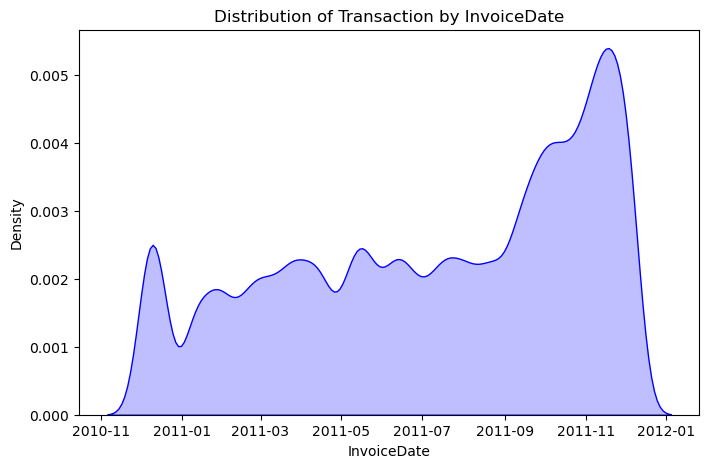

In [22]:
# Plot the density of transactions over time to identify seasonal patterns
plt.figure(figsize=(8, 5))
sns.kdeplot(data['InvoiceDate'], shade=True, color='blue')
plt.title('Distribution of Transaction by InvoiceDate')
plt.xlabel('InvoiceDate')
plt.ylabel('Density')
plt.show()

The plot shows clear yearly seasonality, with transaction density peaking towards the end of the year, likely due to holiday shopping. The 2011 peak is significantly higher than the 2010 peak.

In [23]:
# Define the order of weekdays for plotting
weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

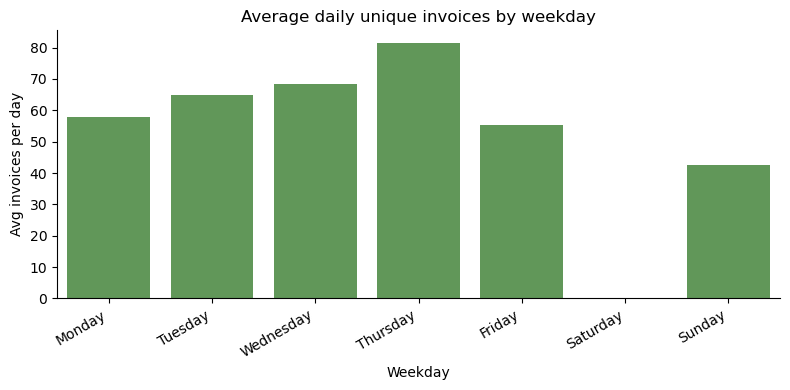

In [24]:
# Calculate the number of unique invoices per day
daily = (
    data.set_index('InvoiceDate')
        .resample('D')['InvoiceNo'].nunique()
        .rename('num_invoices')
        .reset_index()
)

# Extract the weekday name
daily['weekday'] = pd.Categorical(daily['InvoiceDate'].dt.day_name(),
                                  categories=weekday_order, ordered=True)

# Calculate the average number of invoices per weekday
by_weekday_avg = (daily.groupby('weekday')['num_invoices']
                       .mean()
                       .round(2)
                       .reset_index(name='avg_invoices_per_day'))

# Plot the average daily invoices by weekday
plt.figure(figsize=(8,4))
sns.barplot(data=by_weekday_avg, x='weekday', y='avg_invoices_per_day', color='#59A14F')
plt.title('Average daily unique invoices by weekday')
plt.xlabel('Weekday'); plt.ylabel('Avg invoices per day')
plt.xticks(rotation=30, ha='right'); sns.despine(); plt.tight_layout(); plt.show()

**Weekly Pattern:**
* Customers are most active on weekdays, with transaction volume peaking mid-week.
* Weekend activity is significantly lower, which may be due to the company's B2B customer base ordering during standard business hours.

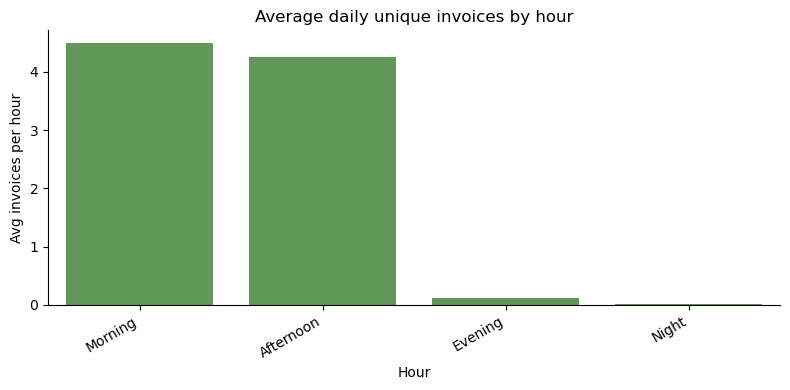

In [25]:
# Define the order of time periods for plotting
hourly_order = ['Morning', 'Afternoon', 'Evening', 'Night']

# Resample data by hour to get unique invoice counts
hourly = (
    data.set_index('InvoiceDate')
        .resample('H')['InvoiceNo'].nunique()
        .rename('num_invoices')
        .reset_index()
)

# Categorize hours into time periods of the day
hourly['period'] = pd.Categorical(
    pd.cut(hourly['InvoiceDate'].dt.hour, 
           bins=[-float('inf'), 6, 12, 18, float('inf')],
           labels=['Night', 'Morning', 'Afternoon', 'Evening']),
    categories=hourly_order, 
    ordered=True)
# Calculate the average hourly invoices by time period
by_hourly_avg = (hourly.groupby('period')['num_invoices']
                       .mean()
                       .round(2)
                       .reset_index(name='avg_invoices_per_day'))

# Plot the average hourly invoices by time period
plt.figure(figsize=(8,4))
sns.barplot(data=by_hourly_avg, x='period', y='avg_invoices_per_day', color='#59A14F')
plt.title('Average daily unique invoices by hour')
plt.xlabel('Hour'); plt.ylabel('Avg invoices per hour')
plt.xticks(rotation=30, ha='right'); sns.despine(); plt.tight_layout(); plt.show()

**Daily Pattern:**
* Transaction activity is highest during business hours (Morning and Afternoon).
* This further supports the hypothesis that a significant portion of customers are wholesalers or corporate clients.

# 2. Feature Engineering
In this section, we will create new features from the existing data to better capture patterns in customer behavior. These engineered features will be more informative for the clustering algorithms than the raw data alone.

## 2.1 Categorical & Text Features

### 2.1.1.  InvoiceNo: Identifying Canceled Transactions

In [26]:
# Create a binary feature to distinguish between completed and canceled orders
data['Cancel_status'] = np.where(data['InvoiceNo'].str.startswith('C'), 'Cancelled', 'Completed')

In [27]:
# Count the number of completed vs. canceled transactions
pd.DataFrame(data['Cancel_status'].value_counts())

,count
Cancel_status,
Completed,381614
Cancelled,3591


### 2.1.2 StockCode: Differentiating Products from Charges

In [28]:
# Count the number of unique product stock codes
data['StockCode'].nunique()

3617

In [29]:
# Display the top 10 most frequently purchased products
data['StockCode'].value_counts().head(10)

StockCode
85123A    2010
22423     1782
85099B    1433
47566     1365
84879     1344
20725     1273
22720     1186
20727     1062
22383     1046
23203     1030
Name: count, dtype: int64

In [30]:
# Examine the unique values in StockCode to identify patterns
data['StockCode'].unique()

array(['85123A', '71053', '84406B', ..., '90214W', '90214Z', '84679'],
      dtype=object)

Some `StockCode` values contain letters. We will investigate if these follow a specific pattern.

In [31]:
# Extract and display the unique letter codes found in StockCode
data['StockCode'].str.extract('([a-zA-Z\s]+)', expand=False).unique()

array(['A', nan, 'B', 'G', 'E', 'L', 'C', 'S', 'BL', 'N', 'POST', 'D',
       'F', 'T', 'H', 'M', 'R', 'K', 'P', 'V', 'J', 'W', 'BANK CHARGES',
       'U', 'Y', 'I', 'DOT', 'CRUK', 'O', 'Z'], dtype=object)

Some codes consist only of letters. These may not be standard products.

In [32]:
# Isolate records where the StockCode contains only letters (no numbers)
anomal_stockcode_data = data[~data['StockCode'].str.contains('^\d+', na=False)]
anomal_stockcode_data['StockCode'].unique()

array(['POST', 'M', 'BANK CHARGES', 'D', 'DOT', 'CRUK'], dtype=object)

Let's examine the descriptions for these non-numeric stock codes.

In [33]:
# Display descriptions for standard, numeric-based stock codes
data[['StockCode', 'Description']].drop_duplicates().reset_index(drop=True)

,StockCode,Description
0,85123A,WHITE HANGING HEART T-LIGHT HOLDER
1,71053,WHITE METAL LANTERN
2,84406B,CREAM CUPID HEARTS COAT HANGER
3,84029G,KNITTED UNION FLAG HOT WATER BOTTLE
4,84029E,RED WOOLLY HOTTIE WHITE HEART.
...,...,...
3838,90214U,"LETTER ""U"" BLING KEY RING"
3839,90214W,"LETTER ""W"" BLING KEY RING"
3840,90214Z,"LETTER ""Z"" BLING KEY RING"
3841,84679,CLASSICAL ROSE TABLE LAMP


In [34]:
# Display descriptions for the anomalous, non-numeric stock codes
anomal_stockcode_data[['StockCode', 'Description']].drop_duplicates().reset_index(drop=True)

,StockCode,Description
0,POST,POSTAGE
1,M,Manual
2,BANK CHARGES,Bank Charges
3,D,Discount
4,DOT,DOTCOM POSTAGE
5,CRUK,CRUK Commission


`StockCodes` with only letters represent non-product charges like "POSTAGE", "Discount", or "Bank Charges". We will create a feature to distinguish these from actual product transactions.

In [35]:
# Create a new feature to categorize transactions as 'Product' or 'Charge'
data['StockCode_type'] = np.where(data['StockCode'].isin(anomal_stockcode_data['StockCode']), 'Charge', 'Product')
data[['StockCode', 'StockCode_type']].head(10)

,StockCode,StockCode_type
0,85123A,Product
1,71053,Product
2,84406B,Product
3,84029G,Product
4,84029E,Product
5,22752,Product
6,21730,Product
7,22633,Product
8,22632,Product
9,84879,Product


In [36]:
# Count the occurrences of each StockCode type
pd.DataFrame(data['StockCode_type'].value_counts())

,count
StockCode_type,
Product,384720
Charge,485


### 2.1.3 Description: Extracting Product Categories

In [37]:
# Display the first 10 product descriptions
data['Description'].head(10)

0     WHITE HANGING HEART T-LIGHT HOLDER
1                    WHITE METAL LANTERN
2         CREAM CUPID HEARTS COAT HANGER
3    KNITTED UNION FLAG HOT WATER BOTTLE
4         RED WOOLLY HOTTIE WHITE HEART.
5           SET 7 BABUSHKA NESTING BOXES
6      GLASS STAR FROSTED T-LIGHT HOLDER
7                 HAND WARMER UNION JACK
8              HAND WARMER RED POLKA DOT
9          ASSORTED COLOUR BIRD ORNAMENT
Name: Description, dtype: object

Some descriptions contain mixed-case letters. For consistency, we will standardize them.

In [38]:
# Check for descriptions with mixed uppercase and lowercase letters
case_mix = [desc for desc in data[data['StockCode_type'] == 'Product']['Description'].unique() if any(char.islower() for char in desc)]
case_mix

['BAG 500g SWIRLY MARBLES',
 'POLYESTER FILLER PAD 45x45cm',
 'POLYESTER FILLER PAD 45x30cm',
 'POLYESTER FILLER PAD 40x40cm',
 'FRENCH BLUE METAL DOOR SIGN No',
 'BAG 250g SWIRLY MARBLES',
 'BAG 125g SWIRLY MARBLES',
 '3 TRADITIONAl BISCUIT CUTTERS  SET',
 'NUMBER TILE COTTAGE GARDEN No',
 'FOLK ART GREETING CARD,pack/12',
 'POLYESTER FILLER PAD 65CMx65CM',
 'NUMBER TILE VINTAGE FONT No ',
 'POLYESTER FILLER PAD 30CMx30CM',
 'POLYESTER FILLER PAD 60x40cm',
 'FLOWERS HANDBAG blue and orange',
 'Next Day Carriage',
 'THE KING GIFT BAG 25x24x12cm',
 'High Resolution Image']

The descriptions "Next Day Carriage" and "High Resolution Image" appear to be service charges rather than products. We will re-categorize them.

In [39]:
# Re-assign 'Next Day Carriage' and 'High Resolution Image' to the 'Charge' category
data.loc[data['Description']== 'Next Day Carriage', 'StockCode_type'] = 'Charge'
data.loc[data['Description']== 'High Resolution Image', 'StockCode_type'] = 'Charge'

Now, we will convert all product descriptions to lowercase for consistent text analysis.

In [40]:
# Convert product descriptions to lowercase
data.loc[data['StockCode_type'] == 'Product', 'Description'] = data['Description'].str.lower()
data['Description'].head(10)

0     white hanging heart t-light holder
1                    white metal lantern
2         cream cupid hearts coat hanger
3    knitted union flag hot water bottle
4         red woolly hottie white heart.
5           set 7 babushka nesting boxes
6      glass star frosted t-light holder
7                 hand warmer union jack
8              hand warmer red polka dot
9          assorted colour bird ornament
Name: Description, dtype: object

For customer segmentation based on product purchases, we will filter out non-product charges.

In [41]:
# Keep only product-related transactions
data = data[data['StockCode_type'] == 'Product']

# Drop the temporary StockCode_type column
data = data.drop(columns=['StockCode_type'])

To understand purchasing patterns, we can extract keywords from product descriptions.

In [42]:
# Define a function to clean text by removing punctuation and extra spaces
def clean_text(t):
    t = re.sub(r"[^a-z\s]", " ", t)
    t = re.sub(r"\s+", " ", t).strip()
    return t

desc_clean = data['Description'].apply(clean_text)

In [43]:
# Use CountVectorizer to extract frequent keywords and two-word phrases
vec = CountVectorizer(
    ngram_range=(1, 2),
    stop_words="english",
    min_df=5,
    token_pattern=r"(?u)\b[a-z]{2,}\b" 
)
X = vec.fit_transform(desc_clean)

In [44]:
# Get top terms/phrases by frequency
term_counts = np.asarray(X.sum(axis=0)).ravel()
vocab = np.array(vec.get_feature_names_out())
order = term_counts.argsort()[::-1]
top_n = 50

# Create keyword features based on top terms
top_terms = pd.DataFrame({
    "term": vocab[order][:top_n],
    "count": term_counts[order][:top_n]
})

# Show the keyword frequency table
top_terms

,term,count
0,set,45869
1,bag,35968
2,red,31379
3,heart,28616
4,retrospot,25760
5,vintage,24884
6,design,22968
7,pink,19845
8,christmas,18280
9,box,17552


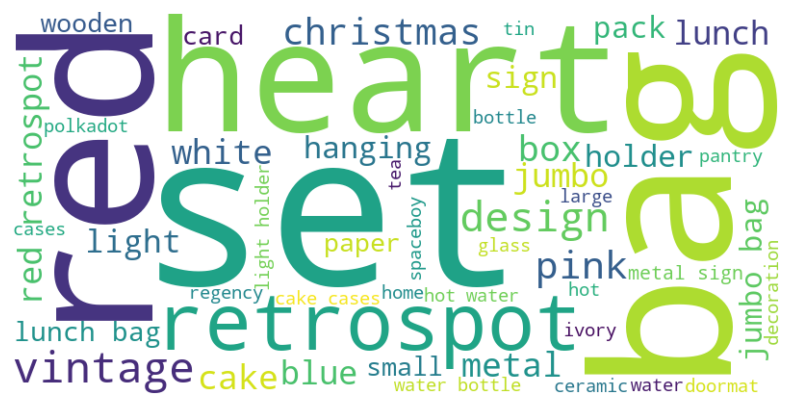

In [45]:
# Generate a word cloud from the most frequent terms
freq_dict = dict(zip(top_terms['term'], top_terms['count']))
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(freq_dict)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

Based on these keywords, we can create high-level product categories to group similar items. This will help us segment customers based on the types of products they prefer.

**Inferred Product Categories**:

* **Gift & Seasonal**: Dominated by terms like "heart," "christmas," "vintage," and "retrospot."
* **Bags & Accessories**: Key terms are "bag," "lunch," and "jumbo."
* **Kitchenware**: Includes "cake," "set," "cup," "mug," and "plate."
* **Home Decor**: Characterized by "box," "sign," "design," "light," "holder," and "decoration."
* **Household Items**: Contains general terms like "metal," "tin," "bottle," and "pantry."

In [46]:
# Define keywords for each product category
categories = {
    "Gift_Seasonal": ["christmas", "heart", "retrospot", "vintage"],
    "Bags_Accessories": ["bag", "lunch", "jumbo"],
    "Kitchenware": ["cake", "set", "cup", "mug", "plate"],
    "Home_Decor": ["box", "sign", "design", "light", "holder", "decoration"],
    "Household": ["metal", "tin", "bottle", "pantry"]
}

In [47]:
# Clean the descriptions
desc_clean = data['Description'].apply(clean_text)

In [48]:
# Create binary features indicating if a product belongs to a category
for cat, keywords in categories.items():
    data[cat] = data["Description"].apply(lambda x: int(any(k in x for k in keywords)))

In [49]:
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Cancel_status,Gift_Seasonal,Bags_Accessories,Kitchenware,Home_Decor,Household
0,536365,85123A,white hanging heart t-light holder,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,Completed,1,0,0,1,0
1,536365,71053,white metal lantern,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,Completed,0,0,0,0,1
2,536365,84406B,cream cupid hearts coat hanger,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,Completed,1,0,1,0,0
3,536365,84029G,knitted union flag hot water bottle,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,Completed,0,0,0,0,1
4,536365,84029E,red woolly hottie white heart.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,Completed,1,0,0,0,0


### 2.1.4 Customer and Geographic Features

In [50]:
# Check the number of unique customers after cleaning
data['CustomerID'].nunique()

4295

In [51]:
# Show the top 10 customers by number of transactions
pd.DataFrame(data['CustomerID'].value_counts(normalize=True).head(10) * 100)

,proportion
CustomerID,
17841,1.997717
14911,1.426792
14096,1.313179
12748,1.125471
14606,0.705337
15311,0.584704
13089,0.468491
13263,0.429494
14298,0.395436


In [52]:
# Show the top 10 customers by total quantity purchased
pd.DataFrame(data.groupby('CustomerID')['Quantity'].sum().sort_values(ascending=False).head(10))

,Quantity
CustomerID,
14911,64671
14646,57646
14298,41889
13089,28477
17511,27564
14156,23927
17841,19975
12415,19874
15311,19696


In [53]:
# Check the number of unique countries
data['Country'].nunique()

37

In [54]:
# List the unique countries
data['Country'].unique()

array(['United Kingdom', 'France', 'Australia', 'Netherlands', 'Germany',
       'Norway', 'EIRE', 'Switzerland', 'Spain', 'Poland', 'Portugal',
       'Italy', 'Belgium', 'Lithuania', 'Japan', 'Iceland',
       'Channel Islands', 'Denmark', 'Cyprus', 'Finland', 'Austria',
       'Sweden', 'Greece', 'Singapore', 'Lebanon', 'United Arab Emirates',
       'Israel', 'Saudi Arabia', 'Czech Republic', 'Canada',
       'Unspecified', 'Brazil', 'USA', 'European Community', 'Bahrain',
       'Malta', 'RSA'], dtype=object)

In [55]:
# Display the top 10 countries by transaction volume
data['Country'].value_counts(normalize=True).head(10) * 100

Country
United Kingdom    89.433729
Germany            2.256141
France             2.064793
EIRE               1.780111
Spain              0.621622
Belgium            0.502809
Switzerland        0.464851
Netherlands        0.396996
Portugal           0.365538
Norway             0.265444
Name: proportion, dtype: float64

Since nearly 90% of transactions are from the UK, we will create a binary feature to separate UK from non-UK customers.

In [56]:
# Create a feature to flag UK vs. Non-UK transactions
data['UK_transaction'] = np.where(data['Country'] == 'United Kingdom', 'UK', 'Non-UK')
pd.DataFrame(data['UK_transaction'].value_counts())

,count
UK_transaction,
UK,343997
Non-UK,40642


## 2.2 Continous Features

### 2.2.1 Total Price

In [57]:
# Create a 'TotalPrice' column for monetary calculations
data['TotalPrice'] = data['Quantity'] * data['UnitPrice']

# Display summary statistics for TotalPrice on completed transactions
completed_data = data[data['Cancel_status'] == 'Completed']
pd.DataFrame(completed_data['TotalPrice'].describe()).round(2)

,TotalPrice
count,381178.00
mean,17.12
std,26.82
min,0.21
25%,4.95
50%,11.80
75%,18.75
max,1356.00


<Axes: ylabel='TotalPrice'>

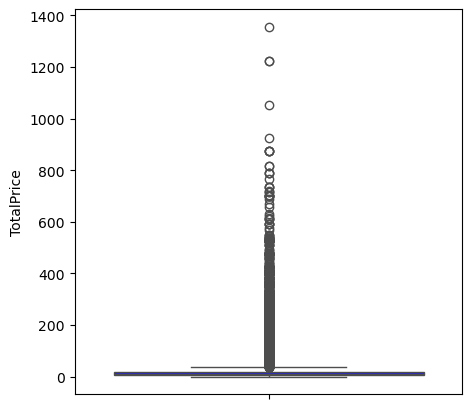

In [58]:
# Boxplot of TotalPrice
plt.figure(figsize=(5, 5))
sns.boxplot(y='TotalPrice', data=completed_data, palette=['blue', 'red'])

We will create a categorical feature based on the total price of each transaction.

The cutoff values for total prices that I will use are below:

* **Low-value orders**: < £50
    * Typical small basket purchases.

* **Medium-value orders**: £50 – £200
    * Customers buying multiple items, possibly gift bundles.

* **High-value orders**: £200 – £500
    * Uncommon but plausible larger baskets.

* **Very high-value orders**: > £500
    * Rare cases, likely bulk orders, wholesale, or anomalies.

In [59]:
# Create bins for the total price of each transaction
# For the cancelled transactions, I will use absolute value of TotalPrice
data['TotalPrice_range'] = pd.cut(data['TotalPrice'].abs(), bins=[0, 50, 200, 500, np.inf], 
                                    labels=["Low", "Medium", "High", "Very High"])
                                    

In [60]:
# Check the proportion of transactions in each price range
data.loc[data['Cancel_status'] == 'Completed', 'TotalPrice_range'].value_counts()

# Check the proportion of transactions in each price range by cancellation status (in %)
pd.DataFrame(data.loc[data['Cancel_status'] == 'Completed', 'TotalPrice_range'].value_counts(normalize=True).head(10) * 100)

,proportion
TotalPrice_range,
Low,94.754419
Medium,4.872264
High,0.354952
Very High,0.018364


Over 94% of all transactions are low-value (under £50).

## 2.3 Time-Based Aggregations
We can create features that summarize purchasing behavior over different time frames.

In [61]:
# Create monthly feature
data["Month"] = data['InvoiceDate'].dt.month
data["Monthly_purchase"] = data.groupby('Month')['InvoiceNo'].transform('nunique')
data["Monthly_spending"] = data.groupby('Month')['TotalPrice'].transform('sum')

In [62]:
# Create weekday feature
data["Weekday"] = data['InvoiceDate'].dt.dayofweek
data["Weekday_purchase"] = data.groupby('Weekday')['InvoiceNo'].transform('nunique')
data["Weekday_spending"] = data.groupby('Weekday')['TotalPrice'].transform('sum')

In [63]:
# Create hour feature
data["Hour"] = data['InvoiceDate'].dt.hour
data["Hour_purchase"] = data.groupby('Hour')['InvoiceNo'].transform('nunique')
data["Hour_spending"] = data.groupby('Hour')['TotalPrice'].transform('sum')

According to the previous EDA, there is a distinct pattern between Christmas season and non-Christmas season. Thus, I will categorize months into **Christmas season** and **non-Christmas** season.

In [64]:
# Create categories for holiday seasons
data['Holiday_season'] = np.where(data['Month'].isin([12, 1, 2]), 'Christmas', 'Non-Christmas')
pd.DataFrame(data['Holiday_season'].value_counts())

,count
Holiday_season,
Non-Christmas,302675
Christmas,81964


According to the previous EDA result, patterns in weekday orders and weekend orders were distinguished. I categorized orders during **weekdays** and **weekends**.

In [65]:
# Create category for weekday
data['Is_Weekday'] = np.where(data['Weekday'].isin([0, 1, 2, 3, 4]), 'Weekday', 'Weekend')
pd.DataFrame(data['Is_Weekday'].value_counts())

,count
Is_Weekday,
Weekday,324201
Weekend,60438


According to the previous EDA, there are distinct patterns of orders in morning/afternoon times and evening/night times. I categorized them into **day** and **night**.

In [66]:
# Create category for hour
data['Is_Daytime'] = np.where(data['Hour'].isin([9, 10, 11, 12, 13, 14, 15, 16]), 'Daytime', 'Nighttime')
pd.DataFrame(data['Is_Daytime'].value_counts())

,count
Is_Daytime,
Daytime,356203
Nighttime,28436


In [67]:
# Display the newly created time-based features
data[["Monthly_purchase", "Monthly_spending", "Weekday_purchase", "Weekday_spending", 
        "Hour_purchase", "Hour_spending", "Holiday_season", "Is_Weekday", "Is_Daytime"]].head(10)

,Monthly_purchase,Monthly_spending,Weekday_purchase,Weekday_spending,Hour_purchase,Hour_spending,Holiday_season,Is_Weekday,Is_Daytime
0,2320,701857.82,3656,1201334.52,559,210698.12,Christmas,Weekday,Nighttime
1,2320,701857.82,3656,1201334.52,559,210698.12,Christmas,Weekday,Nighttime
2,2320,701857.82,3656,1201334.52,559,210698.12,Christmas,Weekday,Nighttime
3,2320,701857.82,3656,1201334.52,559,210698.12,Christmas,Weekday,Nighttime
4,2320,701857.82,3656,1201334.52,559,210698.12,Christmas,Weekday,Nighttime
5,2320,701857.82,3656,1201334.52,559,210698.12,Christmas,Weekday,Nighttime
6,2320,701857.82,3656,1201334.52,559,210698.12,Christmas,Weekday,Nighttime
7,2320,701857.82,3656,1201334.52,559,210698.12,Christmas,Weekday,Nighttime
8,2320,701857.82,3656,1201334.52,559,210698.12,Christmas,Weekday,Nighttime
9,2320,701857.82,3656,1201334.52,559,210698.12,Christmas,Weekday,Nighttime


## 2.4 RFM (Recency, Frequency, Monetary) Features
To get a deeper understanding of customer value and engagement, I will engineer RFM features. These are standard metrics used in marketing to segment customers.

* **Recency (R)**: Days since the customer's last purchase. A lower value indicates a more recent (and potentially more engaged) customer.

In [68]:
# Recency (R): days since last purchase for each customer
data['Recency'] = (data['InvoiceDate'].max() - data['InvoiceDate']).dt.days
data[['CustomerID','Recency']].head(10)

,CustomerID,Recency
0,17850,373
1,17850,373
2,17850,373
3,17850,373
4,17850,373
5,17850,373
6,17850,373
7,17850,373
8,17850,373
9,13047,373


* **Frequency (F)**: The total number of unique invoices (purchases) made by the customer. A higher value suggests greater loyalty.

In [69]:
# Frequency (F): total number of unique invoices per customer
data['Frequency'] = data.groupby('CustomerID')['InvoiceNo'].transform('nunique')
data[['CustomerID','Frequency']].head(10)

,CustomerID,Frequency
0,17850,35
1,17850,35
2,17850,35
3,17850,35
4,17850,35
5,17850,35
6,17850,35
7,17850,35
8,17850,35
9,13047,14


* **Monetary (M)**: The total amount of money spent by the customer. A higher value indicates a higher-value customer.

In [70]:
# Monetary (M): total spending per customer
data['Monetary'] = data.groupby('CustomerID')['TotalPrice'].transform('sum')
data[['CustomerID','Monetary']].head(10)

,CustomerID,Monetary
0,17850,4767.19
1,17850,4767.19
2,17850,4767.19
3,17850,4767.19
4,17850,4767.19
5,17850,4767.19
6,17850,4767.19
7,17850,4767.19
8,17850,4767.19
9,13047,3158.05


# 3. Final Data Preprocessing for Clustering
Before applying distance-based clustering algorithms, it is essential to scale our numerical features and encode our categorical features. This ensures that all features contribute equally to the distance calculations.

In [71]:
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Cancel_status,Gift_Seasonal,...,Weekday_spending,Hour,Hour_purchase,Hour_spending,Holiday_season,Is_Weekday,Is_Daytime,Recency,Frequency,Monetary
0,536365,85123A,white hanging heart t-light holder,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,Completed,1,...,1201334.52,8,559,210698.12,Christmas,Weekday,Nighttime,373,35,4767.19
1,536365,71053,white metal lantern,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,Completed,0,...,1201334.52,8,559,210698.12,Christmas,Weekday,Nighttime,373,35,4767.19
2,536365,84406B,cream cupid hearts coat hanger,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,Completed,1,...,1201334.52,8,559,210698.12,Christmas,Weekday,Nighttime,373,35,4767.19
3,536365,84029G,knitted union flag hot water bottle,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,Completed,0,...,1201334.52,8,559,210698.12,Christmas,Weekday,Nighttime,373,35,4767.19
4,536365,84029E,red woolly hottie white heart.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,Completed,1,...,1201334.52,8,559,210698.12,Christmas,Weekday,Nighttime,373,35,4767.19


In [72]:
# Review the final column names
data.columns

Index(['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'CustomerID', 'Country', 'Cancel_status', 'Gift_Seasonal',
       'Bags_Accessories', 'Kitchenware', 'Home_Decor', 'Household',
       'UK_transaction', 'TotalPrice', 'TotalPrice_range', 'Month',
       'Monthly_purchase', 'Monthly_spending', 'Weekday', 'Weekday_purchase',
       'Weekday_spending', 'Hour', 'Hour_purchase', 'Hour_spending',
       'Holiday_season', 'Is_Weekday', 'Is_Daytime', 'Recency', 'Frequency',
       'Monetary'],
      dtype='object')

In [73]:
# Drop columns that are identifiers or have been superseded by engineered features
data = data.drop(columns=['InvoiceNo', 'StockCode', 'Description', 'InvoiceDate', 'Country', 'TotalPrice',
                            'Month', 'Weekday', 'Hour'])
data.head()

,Quantity,UnitPrice,CustomerID,Cancel_status,Gift_Seasonal,Bags_Accessories,Kitchenware,Home_Decor,Household,UK_transaction,...,Weekday_purchase,Weekday_spending,Hour_purchase,Hour_spending,Holiday_season,Is_Weekday,Is_Daytime,Recency,Frequency,Monetary
0,6,2.55,17850,Completed,1,0,0,1,0,UK,...,3656,1201334.52,559,210698.12,Christmas,Weekday,Nighttime,373,35,4767.19
1,6,3.39,17850,Completed,0,0,0,0,1,UK,...,3656,1201334.52,559,210698.12,Christmas,Weekday,Nighttime,373,35,4767.19
2,8,2.75,17850,Completed,1,0,1,0,0,UK,...,3656,1201334.52,559,210698.12,Christmas,Weekday,Nighttime,373,35,4767.19
3,6,3.39,17850,Completed,0,0,0,0,1,UK,...,3656,1201334.52,559,210698.12,Christmas,Weekday,Nighttime,373,35,4767.19
4,6,3.39,17850,Completed,1,0,0,0,0,UK,...,3656,1201334.52,559,210698.12,Christmas,Weekday,Nighttime,373,35,4767.19


In [74]:
# Separate the features (X) from the customer identifier
X = data.drop(columns=['CustomerID'])

In [75]:
# Define the numeric and categorical features for the transformation pipeline
numeric_features = ['Quantity', 'UnitPrice', 'Monthly_purchase', 'Monthly_spending', 'Weekday_purchase', 'Weekday_spending',
                     'Hour_purchase', 'Hour_spending', 'Recency', 'Frequency', 'Monetary']
categorical_features = ['Cancel_status', 'Gift_Seasonal', 'Bags_Accessories', 'Kitchenware', 'Home_Decor', 'Household',
                       'UK_transaction', 'TotalPrice_range',  'Holiday_season', 'Is_Weekday', 'Is_Daytime']

# Create a preprocessing pipeline with ColumnTransformer
scaling_pipeline = ColumnTransformer(
    transformers=[
        ('onehot', OneHotEncoder(), categorical_features),
        ('scaler', StandardScaler(), numeric_features)
    ],
    remainder='drop',
    sparse_threshold=0
)

In [76]:
# Apply the transformations to the feature set
X_scaled = scaling_pipeline.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=scaling_pipeline.get_feature_names_out())
X_scaled.head()

,onehot__Cancel_status_Cancelled,onehot__Cancel_status_Completed,onehot__Gift_Seasonal_0,onehot__Gift_Seasonal_1,onehot__Bags_Accessories_0,onehot__Bags_Accessories_1,onehot__Kitchenware_0,onehot__Kitchenware_1,onehot__Home_Decor_0,onehot__Home_Decor_1,...,scaler__UnitPrice,scaler__Monthly_purchase,scaler__Monthly_spending,scaler__Weekday_purchase,scaler__Weekday_spending,scaler__Hour_purchase,scaler__Hour_spending,scaler__Recency,scaler__Frequency,scaler__Monetary
0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,...,-0.103914,0.90605,0.456247,0.472988,0.434293,-2.387699,-2.222019,1.96303,0.336539,-0.185909
1,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,...,0.205481,0.90605,0.456247,0.472988,0.434293,-2.387699,-2.222019,1.96303,0.336539,-0.185909
2,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,...,-0.030249,0.90605,0.456247,0.472988,0.434293,-2.387699,-2.222019,1.96303,0.336539,-0.185909
3,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,...,0.205481,0.90605,0.456247,0.472988,0.434293,-2.387699,-2.222019,1.96303,0.336539,-0.185909
4,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,...,0.205481,0.90605,0.456247,0.472988,0.434293,-2.387699,-2.222019,1.96303,0.336539,-0.185909


In [77]:
# Save the feature-engineered data for cluster profiling
X.to_pickle('X_processed.pkl')

In [78]:
# Save the scaled data for modeling
X_scaled.to_pickle('X_scaled.pkl')